# Decision Trees

## What I did in this notebook:
1. Practiced OOP in python.
2. Implemented two impurity measures: Gini and Entropy.
3. Constructed a decision tree algorithm.
4. Pruned the tree to achieve better results.
5. Visualized my results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x2295db33370>, <__main__.Node at 0x2295db338b0>]

## Data preprocessing

For the following notebook, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
data.dropna(how='any', axis=1, inplace=True)

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Now we will implement the functions `calc_gini` and `calc_entropy`.

In [8]:
def data_to_dict(data):
    """
    Insert the data into dictionary where key = attribute, value = amount
    
    Input:
    - data: any dataset columns
    
    Returns the dictionary and number of instances
    """
    class_attributes = data[:,-1]
    count_dict = dict((x,list(class_attributes).count(x)) for x in set(class_attributes))
    num_of_instances = len(class_attributes)
    return count_dict, num_of_instances

In [9]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    
    count_dict, num_of_instances = data_to_dict(data)
    sum = 0
    for i in count_dict:
        sum = sum + ((count_dict[i] / num_of_instances) ** 2)
    gini = 1 - sum

    return gini

In [10]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0

    count_dict, num_of_instances = data_to_dict(data)
    #print(count_dict)
    for i in count_dict:
        p_of_i = count_dict[i] / num_of_instances
        entropy = entropy - (p_of_i * np.log2(p_of_i))

    return entropy

In [11]:
##### Test the results #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch).

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    
    sum = 0
    split = 0
    feature_col = data[:,feature]
    count_dict = dict(zip(*np.unique(feature_col, return_counts=True)))
    
    for attribute, num_of_occurrence in count_dict.items():
        partial_data = data[data[:, feature] == attribute]
        p = num_of_occurrence / len(feature_col)
        
        if gain_ratio == False:
            attribute_impurity = impurity_func(partial_data)
            sum = sum + p * attribute_impurity
            split = 1
            
        else:
            attribute_impurity = calc_entropy(partial_data)
            goodness = calc_entropy(data)
            sum = sum + p * attribute_impurity
            split = split - p * np.log2(p)
            
    goodness = (impurity_func(data) - sum) / split

    return goodness    

In [13]:
print("Gini:")
for i in range(22):
    val = goodness_of_split(X_train, i, calc_gini, False)
    print("The value for feature number", i, "is", val)
print("Entropy:")
for i in range(22):
    val = goodness_of_split(X_train, i, calc_entropy, False)
    print("The value for feature number", i, "is", val)

Gini:
The value for feature number 0 is 0.017909483669059645
The value for feature number 1 is 0.011507415704300583
The value for feature number 2 is 0.01592390784926656
The value for feature number 3 is 0.07558385373221616
The value for feature number 4 is 0.3021007675319315
The value for feature number 5 is 0.005096002067692007
The value for feature number 6 is 0.03892915493429838
The value for feature number 7 is 0.09824806820811527
The value for feature number 8 is 0.14216289154518535
The value for feature number 9 is 0.00313712883389361
The value for feature number 10 is 0.10081895058000273
The value for feature number 11 is 0.1018187601904299
The value for feature number 12 is 0.0833518476460482
The value for feature number 13 is 0.08257658787259409
The value for feature number 14 is 0.0
The value for feature number 15 is 0.007711278430387047
The value for feature number 16 is 0.016871182649675187
The value for feature number 17 is 0.1090630392010622
The value for feature number 

## Building a Decision Tree

Use a Python class to construct the decision tree. The class supports the following functionality:

1. Initiating a node for a decision tree. Every node will hold the feature and value used for the split and its children.
2. Our code supports both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this notebook, when splitting a node create the number of children needed according to the attribute unique values.

We will show now the class `DecisionNode` and the function `build_tree`.

In [14]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature, value):
        self.feature = feature # column index of criteria being tested
        self.value = value
        self.children = []
        self.pred = None
        self.val_count = None
        
    def add_child(self, node):
        self.children.append(node)

In [15]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = DecisionNode(None,None)

    build_tree_helper(data, impurity, root, gain_ratio, min_samples_split, max_depth)

    return root

In [16]:
def build_tree_helper(data, impurity, node, gain_ratio=False, min_samples_split=1, max_depth=1000):
    
    class_attributes = data.T[-1]
    count_dict = dict((x,list(class_attributes).count(x)) for x in set(class_attributes))
    node.val_count = count_dict
    node.pred = max(node.val_count, key=node.val_count.get)
    
    if ((data.shape[0] <= min_samples_split) or (max_depth == 0) or (impurity(data) == 0)):
        return None
    
    best_feature = [-1,-1]
    goodness = 0
    for i in range(data.shape[1] - 1):             
        goodness = goodness_of_split(data, i, impurity, gain_ratio)
        if goodness >= best_feature[1]:
            best_feature[0] = i
            best_feature[1] = goodness
    
    if best_feature[1] <= 0:
        return None
    
    
    class_attributes = data[:,best_feature[0]]
    count_dict = dict((x,list(class_attributes).count(x)) for x in set(class_attributes))
    node.feature = best_feature[0]

    for attribute in count_dict.keys():
        child = DecisionNode(None,attribute)
        node.add_child(child)
    
    for child in node.children:
        partial_data = data[data[:, best_feature[0]] == child.value, :]
        build_tree_helper(partial_data, impurity, child, gain_ratio, min_samples_split, max_depth - 1)
    return None
    

In [17]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

In [18]:
print(len(tree_gini.children))
print(tree_gini.feature)
print(tree_entropy.feature)
print(tree_entropy_gain_ratio.feature)

9
4
4
4


## Tree evaluation

For tree evaluation, we will use the functions `predict` and `calc_accuracy`. 

In [19]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    
    if(node.children != []):
        for child in node.children:
            if (child.value == instance[node.feature]):
                return predict(child, instance) 
    
    return node.pred

In [20]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    
    accurate_predictions = 0
    for instance in dataset:
        labels = instance[-1]
        pred = predict(node,instance)
        if pred == labels:
            accurate_predictions = accurate_predictions + 1
    accuracy = (accurate_predictions / len(dataset)) * 100
    
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree we will print the training and test accuracy. Now, we select the tree that gave us the best test accuracy. For the rest of the notebook, we will using that tree (when we build another tree we will use the same impurity function and same gain_ratio flag). 

In [21]:
print(tree_gini.pred)
print(tree_entropy.pred)
print(tree_entropy_gain_ratio.pred)
print(tree_gini.value)

e
e
e
None


In [22]:
print("calc_accuracy on tree_gini and X_train:", calc_accuracy(tree_gini,X_train))
print("calc_accuracy on tree_entropy and X_train:", calc_accuracy(tree_entropy,X_train))
print("calc_accuracy on tree_entropy_gain_ratio and X_train:", calc_accuracy(tree_entropy_gain_ratio,X_train))
print("calc_accuracy on tree_gini and X_test:", calc_accuracy(tree_gini,X_test))
print("calc_accuracy on tree_entropy and X_test:", calc_accuracy(tree_entropy,X_test))
print("calc_accuracy on tree_entropy_gain_ratio and X_test:", calc_accuracy(tree_entropy_gain_ratio,X_test))

print("\nBy this data, the best tree is tree_entropy_gain_ratio with the values:\ntraining accuracy:", calc_accuracy(tree_entropy_gain_ratio,X_train),"\ttesting accuracy of", calc_accuracy(tree_entropy_gain_ratio,X_test))

calc_accuracy on tree_gini and X_train: 99.21221073362875
calc_accuracy on tree_entropy and X_train: 99.37633349745609
calc_accuracy on tree_entropy_gain_ratio and X_train: 99.67175447234531
calc_accuracy on tree_gini and X_test: 78.38503200393895
calc_accuracy on tree_entropy and X_test: 78.04037419990154
calc_accuracy on tree_entropy_gain_ratio and X_test: 78.68045297882816

By this data, the best tree is tree_entropy_gain_ratio with the values:
training accuracy: 99.67175447234531 	testing accuracy of 78.68045297882816


## Depth pruning


Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, we construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, we calculate the training and testing accuracy.<br>
On a single plot, we will show the training and testing accuracy as a function of the max_depth. The best result will be marked on the graph with red circle.

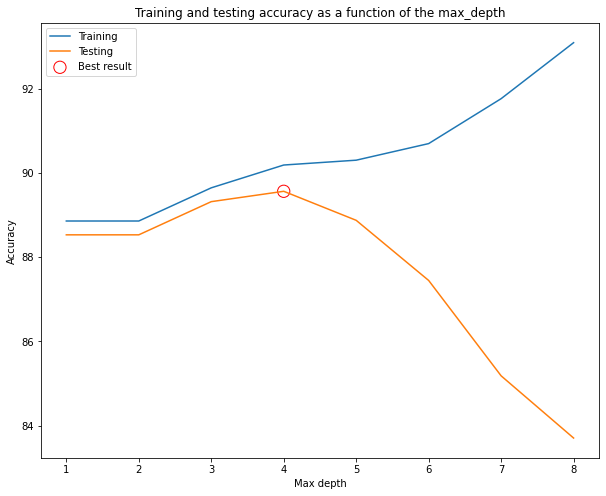

In [23]:
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8]
max_depth_training_trees = []
max_depth_testing_trees = []
max_trees = []

for depth in max_depth_values:
    tree = build_tree(X_train, calc_entropy, True, 1, depth)
    max_trees.append(tree)
    max_depth_training_trees.append(calc_accuracy(tree,X_train))
    max_depth_testing_trees.append(calc_accuracy(tree,X_test))

testing_tree_best_accuracy =  max(max_depth_testing_trees)
best_depth_index = max_depth_testing_trees.index(testing_tree_best_accuracy)


plt.title('Training and testing accuracy as a function of the max_depth')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.plot(max_depth_values, max_depth_training_trees, label = "Training")
plt.plot(max_depth_values, max_depth_testing_trees, label = "Testing")
plt.scatter(max_depth_values[best_depth_index], max_depth_testing_trees[best_depth_index], s=150, color='None', edgecolors='red',label = "Best result")
plt.legend()
plt.show()

## Min Samples Split

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, we will construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, we calculate the training and testing accuracy.<br>
Now we will show, on a single plot, the training and testing accuracy as a function of the min_samples_split. The best result will be marked on the graph with red circle. (the x-axis ticks represent the values of min_samples_split)

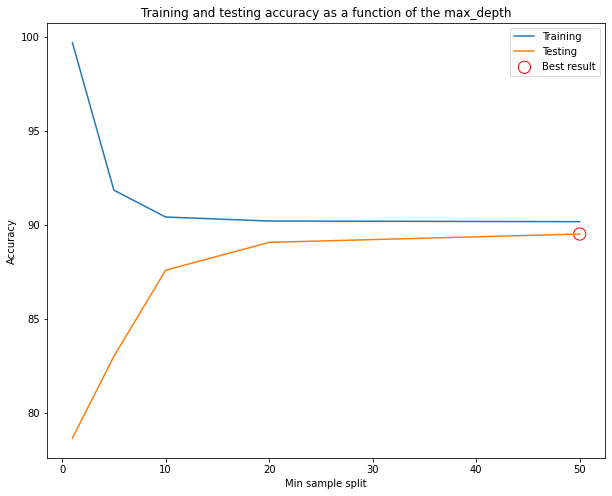

In [24]:
min_samples_split_values = [1, 5, 10, 20, 50]
min_sample_split_training_trees = []
min_sample_split_testing_trees = []
min_trees = []

for split in min_samples_split_values:
    tree = build_tree(X_train, calc_entropy, True, split, 1000)
    min_trees.append(tree)
    min_sample_split_training_trees.append(calc_accuracy(tree,X_train))
    min_sample_split_testing_trees.append(calc_accuracy(tree,X_test))

testing_tree_best_accuracy =  max(min_sample_split_testing_trees)
best_split_index = min_sample_split_testing_trees.index(testing_tree_best_accuracy)


plt.title('Training and testing accuracy as a function of the max_depth')
plt.xlabel('Min sample split')
plt.ylabel('Accuracy')
plt.plot(min_samples_split_values, min_sample_split_training_trees, label = "Training")
plt.plot(min_samples_split_values, min_sample_split_testing_trees, label = "Testing")
plt.scatter(min_samples_split_values[best_split_index], min_sample_split_testing_trees[best_split_index], s=150, color='None', edgecolors='red',label = "Best result")
plt.legend()
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [25]:
best_depth = max_depth_values[best_depth_index]
best_split = min_samples_split_values[best_split_index]

tree_max_depth = build_tree(X_train, calc_entropy, True, 1, best_depth)
tree_min_samples_split = build_tree(X_train, calc_entropy, True, best_split, 1000)

## Number of Nodes

The function counts_nodes will count the number of nodes in a tree, and we use it for each tree from the two trees above

In [26]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """

    return count_nodes_helper(node) + 1 # adding the Root

    

In [27]:
def count_nodes_helper(node):
    if node.children == []:
        return 0
    else:
        count = len(node.children)
        for child in node.children:
            count = count + count_nodes_helper(child)
    return count

In [28]:
print(count_nodes(tree_max_depth))
print(count_nodes(tree_min_samples_split))

207
349


## Print the tree

The function `print_tree`. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

In [41]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    
    if (node.value == None):
        print((" " * depth) + "[" + str(parent_feature) + ", feature=X" + str(node.feature) + "]\n")
        
    if (len(node.children) == 0):
        print((" " * depth) + "[X" + str(parent_feature) + "=" + str(node.value) + ", leaf]: [" + str(node.val_count) + "]\n")
        return
    elif (node.value != None):
        print((" " * depth) + "[" + str(parent_feature) + "=" + str(node.value) + ", feature=X" + str(node.feature) + "]\n")
    
    for child in node.children:
        print_tree(child, depth + 1, node.feature, child.value)

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [42]:
depth_index = -1
best_depth_accuracy = 0
split_index = -1
best_split_accuracy = 0
depth_flag = False
split_flag = False

for i,value in enumerate(max_trees):
    if max_depth_testing_trees[i] > best_depth_accuracy:
        if count_nodes(value) <= 50:
            best_depth_accuracy = max_depth_testing_trees[i]
            depth_index = i
            depth_flag = True
            
for i,value in enumerate(min_trees):
    if min_sample_split_testing_trees[i] > best_split_accuracy:
        if count_nodes(value) <= 50:
            best_split_accuracy = min_sample_split_testing_trees[i]
            split_index = i
            flag2 = True
            
if depth_flag and split_flag:
    if max_depth_testing_trees[depth_index] > min_sample_split_testing_trees[split_index]:
        print_tree(max_trees[depth_index])
    else:
        print_tree(min_trees[split_index])
elif depth_flag:
    print_tree(max_trees[depth_index])
elif split_flag:
    print_tree(min_trees[split_index])
else:
    print("No tree with less than 50 nodes")

[ROOT, feature=X4]

 [X4=p, leaf]: [{'e': 8, 'p': 175}]

 [X4=m, leaf]: [{'e': 2, 'p': 25}]

 [X4=n, leaf]: [{'e': 2332, 'p': 344}]

 [X4=a, leaf]: [{'e': 273, 'p': 31}]

 [X4=c, leaf]: [{'e': 10, 'p': 137}]

 [X4=l, leaf]: [{'e': 272, 'p': 27}]

 [X4=s, leaf]: [{'e': 38, 'p': 380}]

 [X4=f, leaf]: [{'e': 170, 'p': 1438}]

 [X4=y, leaf]: [{'e': 49, 'p': 382}]

